In [64]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook as tqdm


%matplotlib inline

In [3]:
mp=pd.read_csv('datasets/milk_prod/monthly-milk-production.csv', index_col=['Month'],
              parse_dates=['Month'])

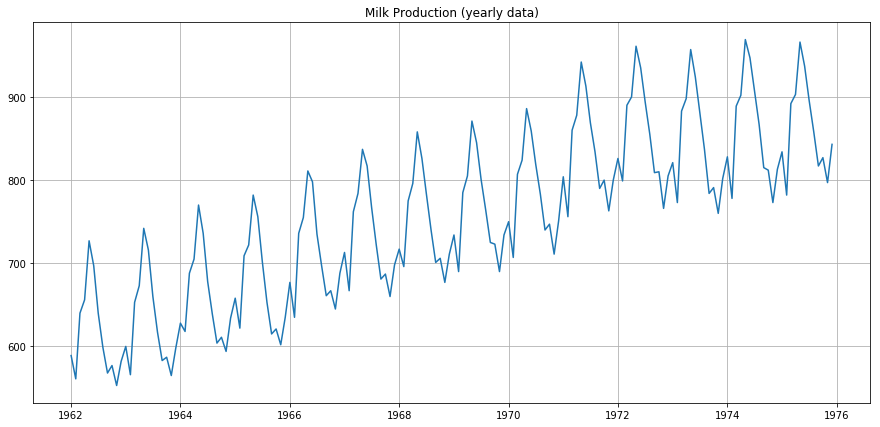

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(mp.MilkProd)
plt.title('Milk Production (yearly data)')
plt.grid(True)
plt.show()

In [6]:
#Forecast quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
#Now that we know how to measure the quality of the forecasts, let's see what 
#metrics we can use and how to translate the results. 
#After that, one small detail remains - building the model.

In [8]:
#Move, smoothe, evaluate
#Let's start with a naive hypothesis: "next year will be the same as this year".
#However, instead of a model like  y^t=yt−1  (which is actually a great baseline 
#for any time series prediction problems and sometimes is impossible to beat), 
#we will assume that the future value of our variable depends on the average of 
#its  k  previous values. 
#Therefore, we will use the moving average.

In [9]:
def moving_average(series, n):
    #Calculate average of last n observations
    return np.average(series[-n:])

moving_average(mp, 12) # prediction for the last observed year (past 12 months)

862.6666666666666

In [10]:
#Unfortunately, we cannot make predictions far in the future.
#In order to get the value for the next step, we need the previous values to be 
#actually observed.
#But moving average has another use case - smoothing the original time series to
#identify trends.
#Pandas has an implementation available with DataFrame.rolling(window).mean(). 
#The wider the window, the smoother the trend.

In [11]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    #series - dataframe with timeseries
    #window - rolling window size 
    #plot_intervals - show confidence intervals
    #plot_anomalies - show anomalies 

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

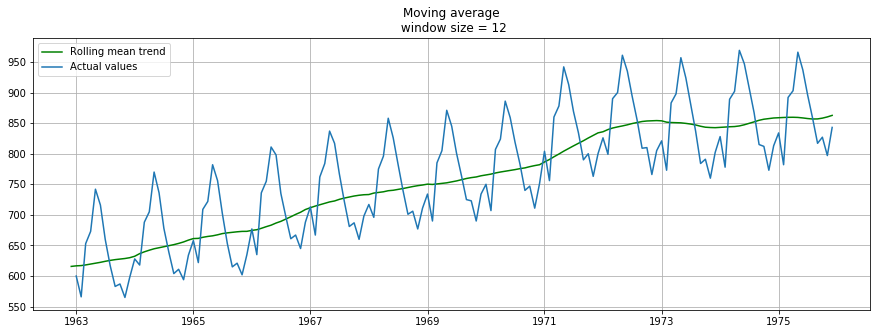

In [12]:
#let's smooth by the previous 12 months
plotMovingAverage(mp, 12)

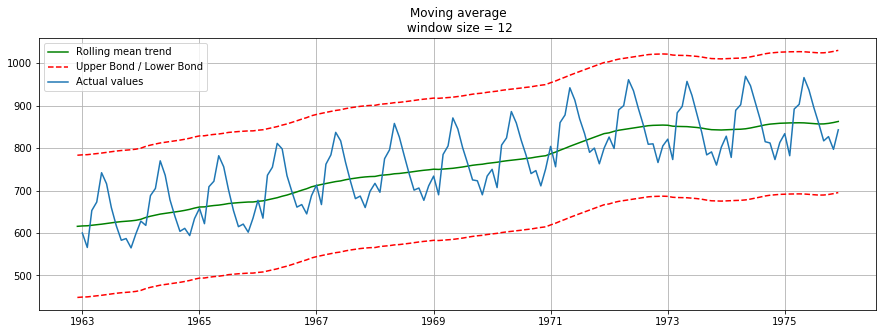

In [13]:
#We can also plot confidence intervals for our smoothed values.
plotMovingAverage(mp, 12, plot_intervals=True)

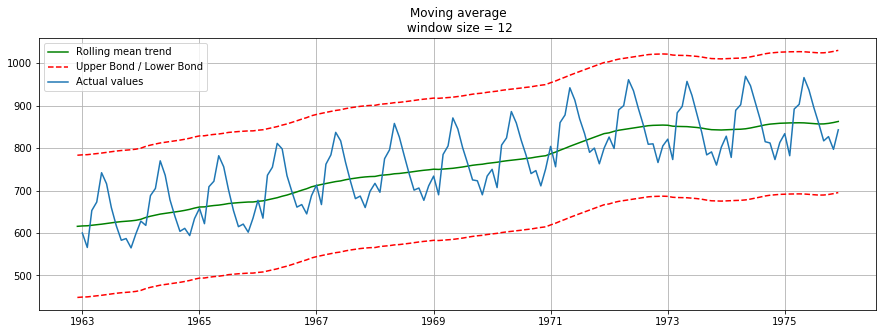

In [16]:
#let's create a simple anomaly detection system with the help of moving average.
plotMovingAverage(mp, 12, plot_intervals=True, plot_anomalies=True)

In [17]:
#No anomalies, data is more or less normal
#However if you want to avoid false positives, it is best to consider more 
#complex models.

In [18]:
#Weighted average is a simple modification to the moving average. The weights 
#sum up to 1 with larger weights assigned to more recent observations.
def weighted_average(series, weights):
    
    #Calculate weighted average on series
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [19]:
(mp, [0.6, 0.3, 0.1])

(            MilkProd
 Month               
 1962-01-01       589
 1962-02-01       561
 1962-03-01       640
 1962-04-01       656
 1962-05-01       727
 1962-06-01       697
 1962-07-01       640
 1962-08-01       599
 1962-09-01       568
 1962-10-01       577
 1962-11-01       553
 1962-12-01       582
 1963-01-01       600
 1963-02-01       566
 1963-03-01       653
 1963-04-01       673
 1963-05-01       742
 1963-06-01       716
 1963-07-01       660
 1963-08-01       617
 1963-09-01       583
 1963-10-01       587
 1963-11-01       565
 1963-12-01       598
 1964-01-01       628
 1964-02-01       618
 1964-03-01       688
 1964-04-01       705
 1964-05-01       770
 1964-06-01       736
 ...              ...
 1973-07-01       881
 1973-08-01       837
 1973-09-01       784
 1973-10-01       791
 1973-11-01       760
 1973-12-01       802
 1974-01-01       828
 1974-02-01       778
 1974-03-01       889
 1974-04-01       902
 1974-05-01       969
 1974-06-01       947
 1974-07-0

In [20]:
#Exponential smoothing
# let's see what happens if, instead of weighting the last  k  values of the time
#series, we start weighting all available observations while exponentially 
#decreasing the weights as we move further back in time
#Here the model value is a weighted average between the current true value and 
#the previous model values. The  α  weight is called a smoothing factor. 
#It defines how quickly we will "forget" the last available true observation. 
#The smaller  α  is, the more influence the previous observations have and the 
#smoother the series is.

def exponential_smoothing(series, alpha):
   
    #series - dataset with timestamps
    #alpha - float [0.0, 1.0], smoothing parameter
  
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [21]:
def plotExponentialSmoothing(series, alphas):
    #Plots exponential smoothing with different alphas
    #series - dataset with timestamps
    #alphas - list of floats, smoothing parameters
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

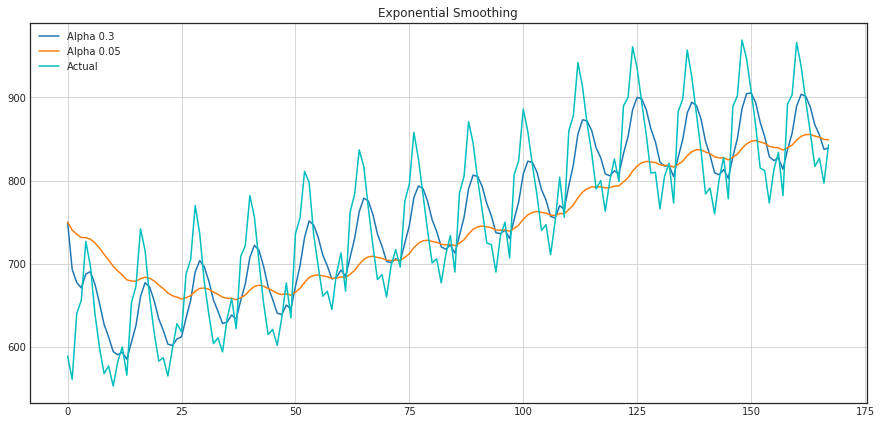

In [22]:
plotExponentialSmoothing(mp.MilkProd, [0.3, 0.05])

In [23]:
#Double exponential smoothing
#Up to now, the methods that we've discussed have been for a single future point
#prediction (with some nice smoothing).
#Let's extend exponential smoothing so that we can predict two future points 
#(of course, we will also include more smoothing).
def double_exponential_smoothing(series, alpha, beta):
    #series - dataset with timeseries
    #alpha - float [0.0, 1.0], smoothing parameter for level
    #beta - float [0.0, 1.0], smoothing parameter for trend
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


In [24]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    #Plots double exponential smoothing with different alphas and betas   
    #series - dataset with timestamps
    #alphas - list of floats, smoothing parameters for level
    #betas - list of floats, smoothing parameters for trend
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

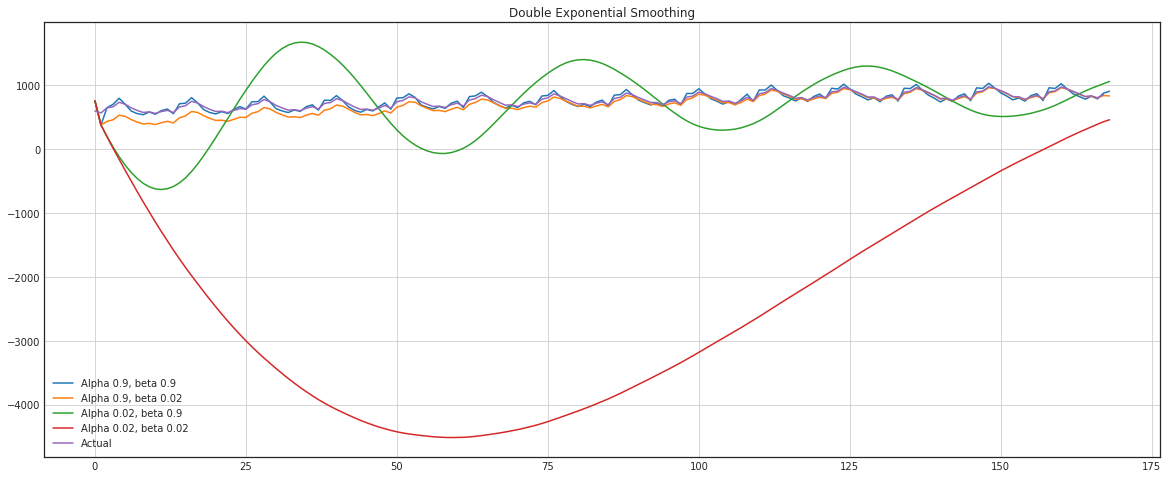

In [25]:
plotDoubleExponentialSmoothing(mp.MilkProd, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [26]:
#Now we have to tune two parameters:  α  and  β . The former is responsible for 
#the series smoothing around the trend, the latter for the smoothing of the 
#trend itself. 
#The larger the values, the more weight the most recent observations will have 
#and the less smoothed the model series will be

In [27]:
#Triple exponential smoothing a.k.a. Holt-Winters
#the idea is to add a third component - seasonality. This means that we should 
#not use this method if our time series is not expected to have seasonality. 
#Seasonal components in the model will explain repeated variations around 
#intercept and trend, and it will be specified by the length of the season, 
#in other words by the period after which the variations repeat. 
#For each observation in the season, there is a separate component; for example,
#if the length of the season is 7 days (a weekly seasonality), we will have 7 
#seasonal components, one for each day of the week.
class HoltWinters:

    #Holt-Winters model with the anomalies detection using Brutlag method
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals
    
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                self.PredictedDeviation.append(0)
                self.UpperBond.append(self.result[0] + self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
    
                 # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
                

In [28]:
#Time series cross validation
#Before we start building a model, let's first discuss how to estimate model 
#parameters automatically.
#There is nothing unusual here; as always, we have to choose a loss function 
#suitable for the task that will tell us how closely the model approximates the 
#data.
#Then, using cross-validation, we will evaluate our chosen loss function for the
#given model parameters, calculate the gradient, adjust the model parameters, 
#and so on, eventually descending to the global minimum.
#time series have this temporal structure and one cannot randomly mix values in 
#a fold while preserving this structure. 
#With randomization, all time dependencies between observations will be lost. 
#This is why we will have to use a more tricky approach in optimizing the model 
#parameters i.e.  "cross-validation on a rolling basis".
#The idea is rather simple -- 
#we train our model on a small segment of the time series from the beginning 
#until some  t , make predictions for the next  t+n steps, and calculate an 
#error. 
#Then, we expand our training sample to  t+n value, make predictions from  t+n  
#until  t+2∗n , and continue moving our test segment of the time series until 
#we hit the last available observation. 
#As a result, we have as many folds as  n  will fit between the initial training
#sample and the last observation.

In [29]:
#Now, knowing how to set up cross-validation, we can find the optimal parameters
#for the Holt-Winters model. 
#Recall that we have yearly/annual seasonality in mp, hence the slen=12 parameter
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=12):
    #Returns error on CV  
    #params - vector of parameters for optimization
    #series - dataset with timeseries
    #slen - season length for Holt-Winters model
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [31]:
#In the Holt-Winters model, as well as in the other models of exponential 
#smoothing, there's a constraint on how large the smoothing parameters can be, 
#each of them ranging from 0 to 1. Therefore, in order to minimize our loss 
#function, we have to choose an algorithm that supports constraints on model 
#parameters. In our case, we will use the truncated Newton conjugate gradient.
#%%time
data = mp.MilkProd[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.8182186575208347 0.0 0.7863493386162461


In [33]:
#Let's add some code to render plots.
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    #series - dataset with timeseries
    #plot_intervals - show confidence intervals
    #plot_anomalies - show anomalies 
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    

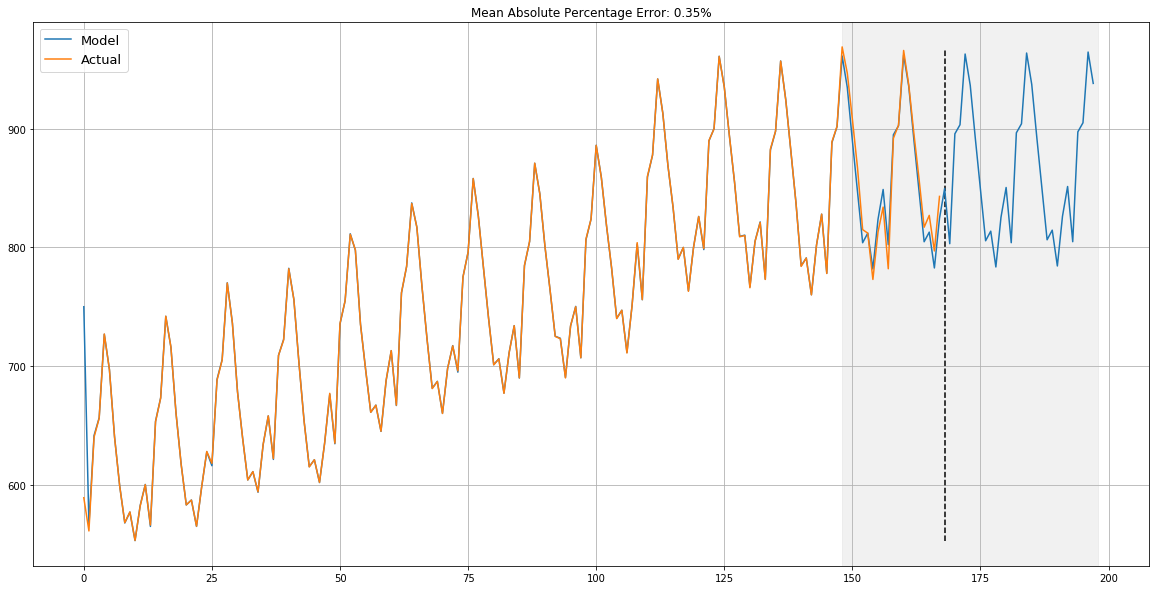

In [34]:
plotHoltWinters(mp.MilkProd)

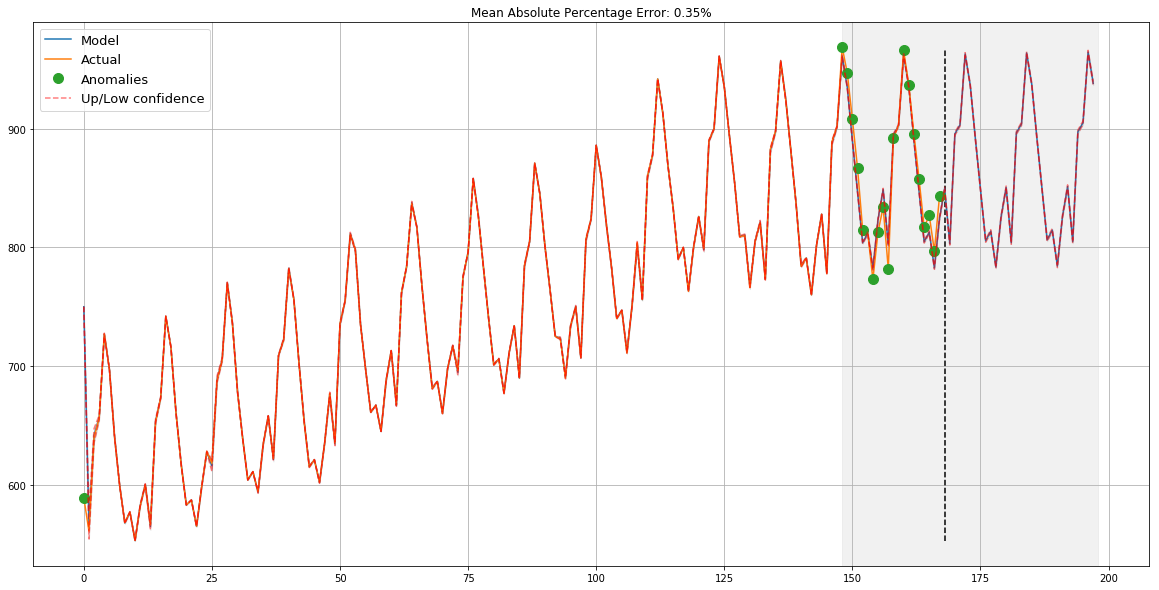

In [35]:
plotHoltWinters(mp.MilkProd, plot_intervals=True, plot_anomalies=True)

In [36]:
#Judging by the plots, our model was able to successfully approximate the 
#initial time series, capturing the annual seasonality, overall upwards trend, 
#and even some anomalies.

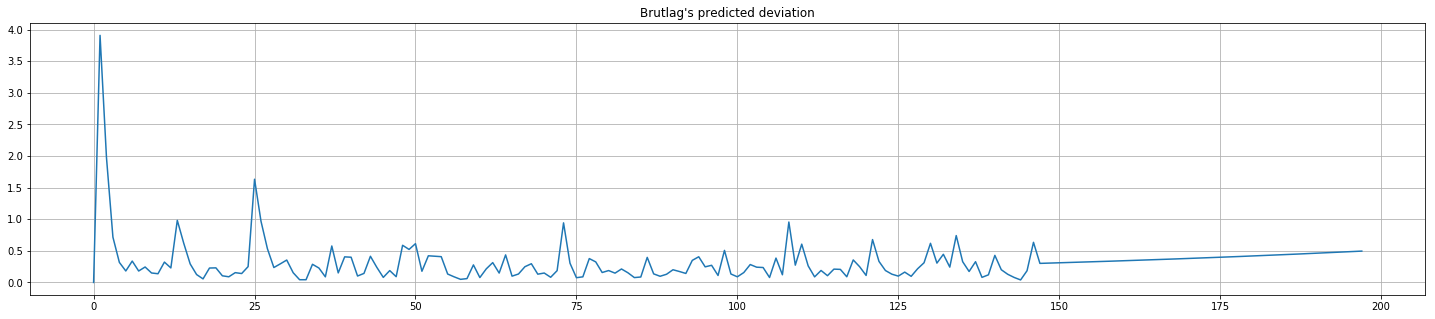

In [37]:
#If you look at the model deviations, you can clearly see that the model reacts 
#quite sharply to changes in the structure of the series but then quickly 
#returns the deviation to the normal values, essentially "forgetting" the past. 
#This feature of the model allows us to quickly build anomaly detection systems,
#even for noisy series data, without spending too much time and money on 
#preparing the data and training the model.
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");


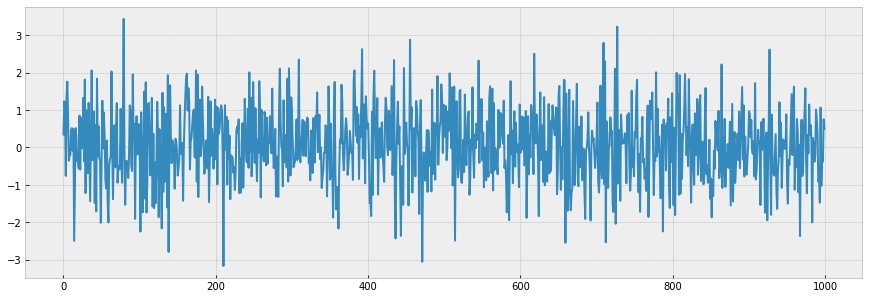

In [38]:
#Econometric approach-Stationarity
#If a process is stationary, that means it does not change its statistical 
#properties over time, namely its mean and variance.
#Stationarity is so important because it is easy to make predictions on a 
#stationary series since we can assume that the future statistical properties 
#will not be different from those currently observed. Most of the time-series 
#models, in one way or the other, try to predict those properties (mean or 
#variance, for example).
#Furture predictions would be wrong if the original series were not stationary. 
#In order to combat non-stationarity, we have to know our enemy, so to speak. 
#Let's see how we can detect it.
#We will look at white noise and random walks to learn how to get from one to 
#another for free.

white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

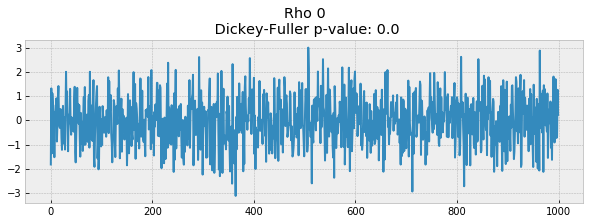

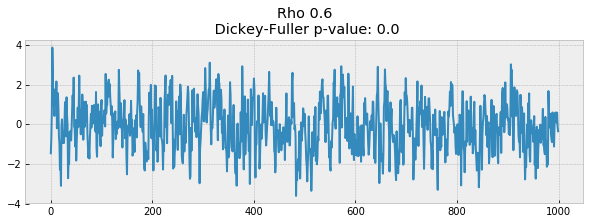

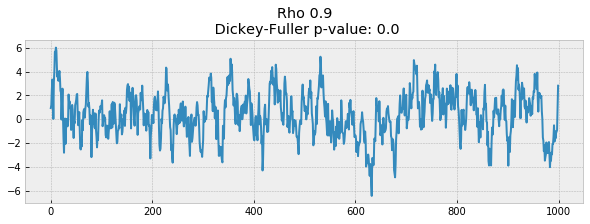

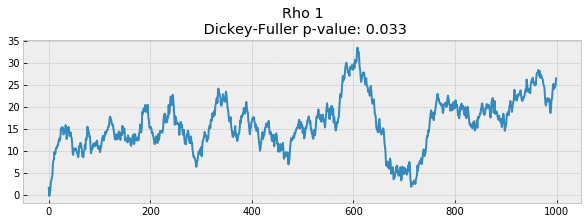

In [39]:
#The process generated by the standard normal distribution is stationary and 
#oscillates around 0 with with deviation of 1. 
#Now, based on this process, we will generate a new one where each subsequent 
#value will depend on the previous one:  
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

In [40]:
#On the first plot, you can see the same stationary white noise as before. 
#On the second plot with  ρ  increased to 0.6, wider cycles appeared, but it 
#still appears stationary overall. The third plot deviates even more from the 
#0 mean but still oscillates about the mean. Finally, with  ρ=1 , we have a 
#random walk process i.e. a non-stationary time series.

In [41]:
# If we can get a stationary series from a non-stationary series using the first
#difference(i.e. Dickey-Fuller test), we call those series integrated of order 1.
#The null hypothesis of the test is that the time series is non-stationary, 
#which was rejected on the first three plots and finally accepted on the last 
#one. 
#We have to say that the first difference is not always enough to get a 
#stationary series as the process might be integrated of order d, d > 1 (and have
#multiple unit roots). In such cases, the augmented Dickey-Fuller test is used, 
#which checks multiple lags at once.
#We can fight non-stationarity using different approaches: 
#various order differences, trend and seasonality removal, smoothing, and 
#transformations like Box-Cox or logarithmic.

In [42]:
#Getting rid of non-stationarity and building SARIMA
#Let's build an ARIMA model by walking through all the stages of making a series 
#stationary:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
        #Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        #y - timeseries
        #lags - how many lags to include in ACF, PACF calculation

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

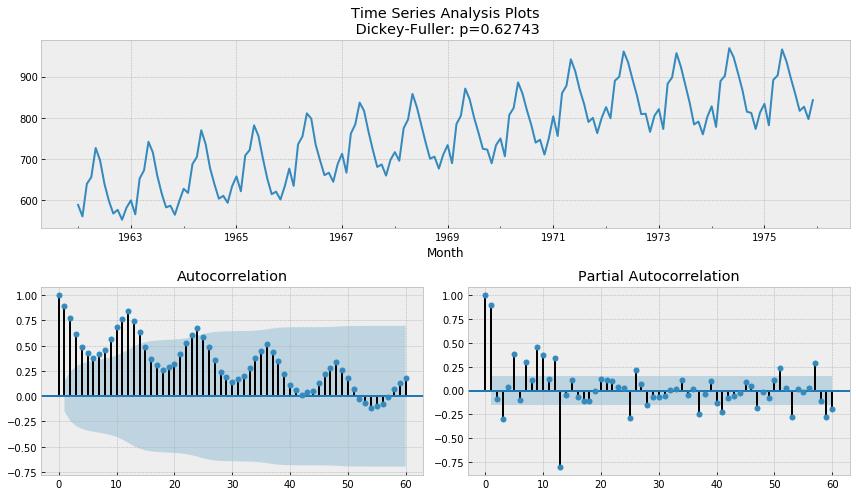

In [43]:
tsplot(mp.MilkProd, lags=60)

In [44]:
#We can see on the plot that we have a visible trend, so the mean is NOT constant 
#and the variance is NOT stable
#The Dickey-Fuller test accepted the null hypothesis

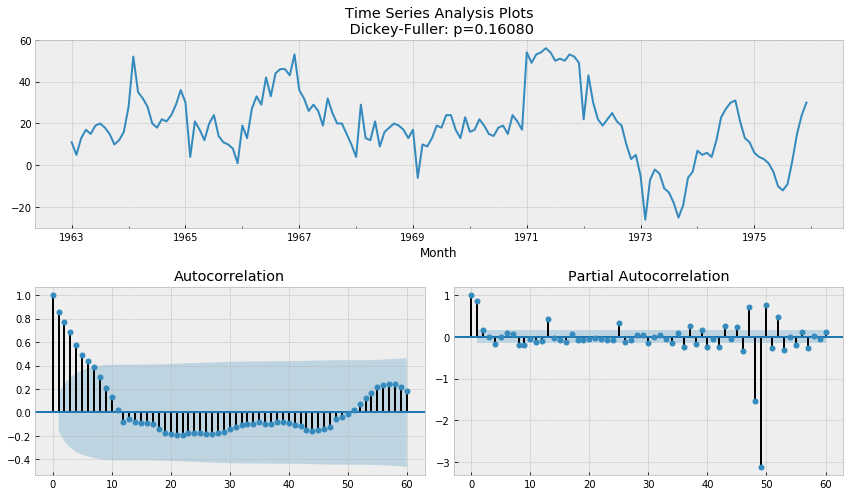

In [45]:
#The only thing left is seasonality, which we have to deal with prior to modeling. 
#To do so, let's take the "seasonal difference", which means a simple 
#subtraction of the series from itself with a lag that equals the seasonal period.

mp_diff = mp.MilkProd - mp.MilkProd.shift(12)
tsplot(mp_diff[12:], lags=60)

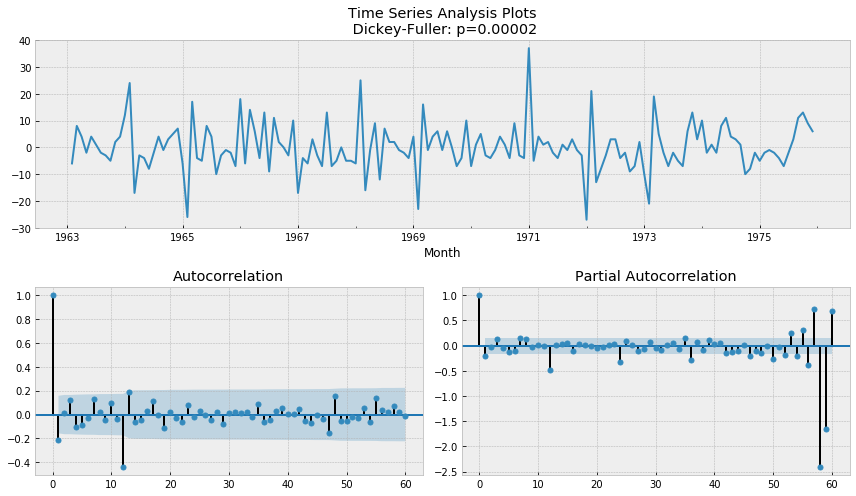

In [46]:
#It is now much better with the visible seasonality gone. 
#However, the autocorrelation function still has too many significant lags. 
#To remove them, we'll take first differences, subtracting the series from itself
#with lag 1.
mp_diff = mp_diff - mp_diff.shift(1)
tsplot(mp_diff[12+1:], lags=60)

In [47]:
#Perfect! Our series now looks like something undescribable, oscillating around 
#zero. The Dickey-Fuller test indicates that it is stationary, and the number of
#significant peaks in ACF has dropped. 
#We can finally start modeling!

In [48]:
#ARIMA-family Crash-Course
#SARIMA(p,d,q)(P,D,Q,s) , Seasonal Autoregression Moving Average model:
#AR(p)  - autoregression model i.e. regression of the time series onto itself. 
#The basic assumption is that the current series values depend on its previous 
#values with some lag (or several lags). The maximum lag in the model is 
#referred to as p. To determine the initial p, you need to look at the PACF plot
#and find the biggest significant lag after which most other lags become 
#insignificant.
#MA(q) - moving average model. Without going into too much detail, 
#this models the error of the time series, again with the assumption that the 
#current error depends on the previous with some lag, which is referred to as q.
#The initial value can be found on the ACF plot with the same logic as before.

#AR(p)+MA(q)=ARMA(p,q) 
#What we have here is the Autoregressive–moving-average model! If the series is 
#stationary, it can be approximated with these 4 letters. 

#I(d) - order of integration. This is simply the number of nonseasonal 
#differences needed to make the series stationary. In our case, it's just 1 
#because we used first differences.
#Adding this letter to the four gives us the  ARIMA  model which can handle 
#non-stationary data with the help of nonseasonal differences

#S(s)  - this is responsible for seasonality and equals the season period length
#of the series
#With this, we have three parameters:  (P,D,Q) 
#P  - order of autoregression for the seasonal component of the model, which can
#be derived from PACF. But you need to look at the number of significant lags, 
#which are the multiples of the season period length. For example, if the period
#equals 12 and we see the 12-th and 24-th lags are significant in the PACF, that
#means the initial  P  should be 2.
#Q  - similar logic using the ACF plot instead.
#D  - order of seasonal integration. This can be equal to 1 or 0, depending on 
#whether seasonal differeces were applied or not.

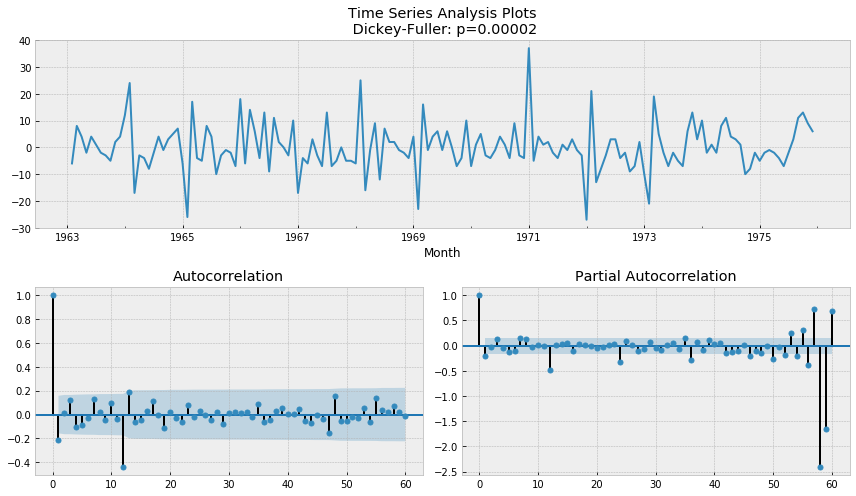

In [50]:
#Now that we know how to set the initial parameters, let's have a look at the 
#final plot once again and set the parameters:
tsplot(mp_diff[12+1:], lags=60)

In [51]:
#Let's test various models and see which one is better.
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [52]:
def optimizeSARIMA(parameters_list, d, D, s):

        #Return dataframe with parameters and corresponding AIC
        
        #parameters_list - list with (p, q, P, Q) tuples
        #d - integration order in ARIMA model
        #D - seasonal integration order 
        #s - length of season
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [53]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

NameError: name 'tqdm_notebook' is not defined

In [65]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(mp.MilkProd, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

NameError: name 'result_table' is not defined